In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers

import io
import json
from os import path
import glob

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [3]:
# Dataset path
record_dir = path.join('..', 'data', '2d_data', 'tf_records', 'zebrafish_and_beads', 'sims')
dataset_files = glob.glob(path.join(record_dir, '*'))

In [4]:
input_shape = (len(dataset_files), 648, 486, 1)
obj_dims = (648, 486)

In [5]:
model_weights_path = path.join('..', 'models', '2d_models', 'zebrafish_and_beads_with_noise', 'model_1')

# Layers

#### Shifted + scaled tanh activation function

In [8]:
# Batchnorm epsilon
BN_EPS = 1e-4

class ConvBnRelu2d(layers.Layer):
    def __init__(self, out_channels, kernel_size=(3, 3), padding='same'):
        super(ConvBnRelu2d, self).__init__()
        self.conv = layers.Conv2D(filters=out_channels, kernel_size=kernel_size, padding='same', use_bias=False)
        self.bn = layers.BatchNormalization(epsilon=BN_EPS)
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

class TanhScale(layers.Layer):
    def __init__(self):
        super(TanhScale, self).__init__()
    
    def call(self, x):
        x = K.tanh(x)
        x = (x + 1) * 0.5
        return x * m

class StackEncoder(layers.Layer):
    def __init__(self, y_channels, kernel_size=3):
        super(StackEncoder, self).__init__()
        padding = (kernel_size - 1) // 2
        self.encode = keras.Sequential([
            ConvBnRelu2d(y_channels, kernel_size=kernel_size, padding='same'),
            ConvBnRelu2d(y_channels, kernel_size=kernel_size, padding='same')
        ])
        self.max_pool = layers.MaxPool2D(pool_size=2, strides=2)
        
    def call(self, x):
        x = self.encode(x)
        x_small = self.max_pool(x)
        return x, x_small


class StackDecoder(layers.Layer):
    def __init__(self, y_channels, kernel_size=3):
        super(StackDecoder, self).__init__()
        padding = (kernel_size - 1) // 2
        
        self.decode = keras.Sequential([
            ConvBnRelu2d(y_channels, kernel_size=kernel_size, padding='same'),
            ConvBnRelu2d(y_channels, kernel_size=kernel_size, padding='same'),
            ConvBnRelu2d(y_channels, kernel_size=kernel_size, padding='same'),
            ]
        )
        
        
    def call(self, x, down_tensor):
        x = layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(x)
        
        # Calculate cropping for down_tensor to concatenate with x
        _, h2, w2, _ = down_tensor.shape
        _, h1, w1, _ = x.shape
        h_diff, w_diff = h2 - h1, w2 - w1
        
        cropping = ((int(np.ceil(h_diff / 2)), int(np.floor(h_diff / 2))),
                    (int(np.ceil(w_diff / 2)), int(np.floor(w_diff / 2))))
        down_tensor = layers.Cropping2D(cropping=cropping)(down_tensor)        
        x = layers.concatenate([x, down_tensor], axis=3)
        x = self.decode(x)
        return x

# Model

In [9]:
class UNet_2d(keras.Model):
    def __init__(self):
        super(UNet_2d, self).__init__()

        self.down1 = StackEncoder(24, kernel_size=3) # 256
        self.down2 = StackEncoder(64, kernel_size=3)  # 128
        self.down3 = StackEncoder(128, kernel_size=3)  # 64
        self.down4 = StackEncoder(256, kernel_size=3)  # 32
        self.down5 = StackEncoder(512, kernel_size=3)  # 16
        

        self.up5 = StackDecoder(256, kernel_size=3)  # 32
        self.up4 = StackDecoder(128, kernel_size=3)  # 64
        self.up3 = StackDecoder(64, kernel_size=3)  # 128
        self.up2 = StackDecoder(24, kernel_size=3)  # 256
        self.up1 = StackDecoder(24, kernel_size=3)  # 512
        self.classify = layers.Conv2D(filters=1, kernel_size=1, use_bias=True)
        
        self.center = ConvBnRelu2d(512, kernel_size=3, padding='same')
        
        
    def call(self, x):
        out = x;
        down1_tensor, out = self.down1(out)
        down2_tensor, out = self.down2(out)
        down3_tensor, out = self.down3(out)
        down4_tensor, out = self.down4(out)
        down5_tensor, out = self.down5(out)

        out = self.center(out)
        
        out = self.up5(out, down5_tensor)
        out = self.up4(out, down4_tensor)
        out = self.up3(out, down3_tensor)
        out = self.up2(out, down2_tensor)
        out = self.up1(out, down1_tensor)

        out = self.classify(out)
        out = tf.squeeze(out, axis=3)
        
        return out

In [10]:
#         out = self.activation_fn(out)
#         self.activation_fn = TanhScale()
#       self.bn = layers.BatchNormalization(epsilon=BN_EPS)

# TFRecords Dataset Creation

In [11]:
def _parse_function(example_proto):
#     eps = 1e-1
    feature_description = {
        'plane': tf.io.FixedLenFeature(obj_dims, tf.float32),
        'sim': tf.io.FixedLenFeature(obj_dims, tf.float32)
    }
    # Parse the input tf.Example proto using the dictionary above.
    example = tf.io.parse_single_example(example_proto, feature_description)
    
    plane = example['plane']
    plane = tf.cast(plane, tf.float16)
    plane = plane[4:644, 3:483] # Crop to target image size
    plane_max = tf.reduce_max(plane)
    plane_min = tf.reduce_min(plane)
    plane = (plane - plane_min) / (plane_max - plane_min)

    sim = example['sim']
    sim = tf.cast(sim, tf.float16)
    sim_max = tf.reduce_max(sim)
    sim_min = tf.reduce_min(sim)
    sim = (sim - sim_min) / (sim_max - sim_min) # Normalize values to [0, 1]
    
    # Adding noise to simulated measurements
    a = 0.0063*2
    b = 0.04*2
    noise = a*np.random.randn(*sim.shape) + b
    
    sim = sim + noise

    # Renormalize values to [0, 1]
    sim_max = tf.reduce_max(sim)
    sim_min = tf.reduce_min(sim)
    sim = (sim - sim_min) / (sim_max - sim_min) # Normalize values to [0, 1]
    
    sim = sim[..., np.newaxis] # Expand to channel dimension
    
    return sim, plane

In [12]:
def create_datasets(filenames, train_length, val_length, batch_size):
    """
    Takes in string array of filenames for TFRecord files containing samples.
    Returns: train dataset of train_length, val dataset of val_length
    """
    filenames = tf.random.shuffle(filenames)
#     raw_dataset = tf.data.TFRecordDataset(filenames=filenames)

    raw_train_dataset = tf.data.TFRecordDataset(filenames[:train_length])
    raw_val_dataset = tf.data.TFRecordDataset(filenames[train_length:train_length + val_length])
    
    train_dataset = raw_train_dataset.map(_parse_function)
    train_dataset = train_dataset.shuffle(256)
    train_dataset = train_dataset.repeat()
    train_dataset = train_dataset.batch(batch_size)
    
    
    val_dataset = raw_val_dataset.map(_parse_function)
    val_dataset = val_dataset.shuffle(256)
    val_dataset = val_dataset.batch(batch_size)
    
    return train_dataset, val_dataset

# Logging

In [ ]:
def plot_to_image(figure):
    """Converts the matplotlib plot specified by 'figure' to a PNG image and
    returns it. The supplied figure is closed and inaccessible after this call."""
    # Save the plot to a PNG in memory.
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    # Closing the figure prevents it from being displayed directly inside
    # the notebook.
    plt.close(figure)
    buf.seek(0)
    # Convert PNG buffer to TF image
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    # Add the batch dimension
    image = tf.expand_dims(image, 0)
    return image

def scaled_mse_loss(y_actual,y_pred):
    loss = K.square((y_actual-y_pred))
#     loss = K.sqrt(loss)
    loss = K.sum(loss)
    return loss

def plot_image_tensorboard(epoch, logs):
    # Create a plot to visualize image reconstruction progress
    
    # Call the model to get prediction
    pred = model.predict(val_sample[0][0][np.newaxis])

    # Create a mpl figure
    figure = plt.figure(figsize=(10,10))

    # Plot the prediction
    plt.subplot(1, 2, 1)
    plt.title("prediction")
    plt.imshow(pred[0].astype(np.float32))
    # Plot groundtruth
    plt.subplot(1, 2, 2)
    plt.title("ground truth")
    plt.imshow(val_sample[1][0].numpy().astype(np.float32))
    plot_image = plot_to_image(figure)
    with file_writer.as_default():
        tf.summary.image("Prediction vs Ground Truth", plot_image, step=epoch)

import datetime
log_dir=os.path.join('logs_2d', 'fit') + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch=1000000)
file_writer = tf.summary.create_file_writer(log_dir)

plot_image_tensorboard_cb = keras.callbacks.LambdaCallback(on_epoch_end=plot_image_tensorboard)

# Training

In [ ]:
model = UNet_2d()
adam = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, amsgrad=False)
# model.compile(optimizer=adam, loss=scaled_mse_loss, metrics=['mean_squared_error'])
model.compile(optimizer=adam, loss='mean_squared_error', metrics=['mean_squared_error'])
model.build(input_shape)
model.summary()

In [20]:
DATASET_LENGTH = len(dataset_files)
TRAIN_LENGTH = int(DATASET_LENGTH * 0.9)
VAL_LENGTH = DATASET_LENGTH - TRAIN_LENGTH 

EPOCHS = 60
BATCH_SIZE = 8
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

train_dataset, val_dataset = create_datasets(filenames=dataset_files, train_length=TRAIN_LENGTH, 
                                  val_length=VAL_LENGTH, batch_size=BATCH_SIZE)

In [ ]:
val_sample = next(iter(val_dataset))

In [ ]:
model.fit(train_dataset, epochs=EPOCHS, steps_per_epoch=STEPS_PER_EPOCH, 
          callbacks=[plot_image_tensorboard_cb, tensorboard_callback], validation_data=val_dataset, validation_steps=10)

In [ ]:
model.save_weights(model_weights_path, save_format='tf')

# Timing Tests 

In [21]:
NUM_DISPLAY = 15

In [22]:
model = UNet_2d()
model.load_weights(model_weights_path)

In [23]:
import time

In [24]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [25]:
preds = np.zeros((NUM_DISPLAY, 640, 480))
ground_truths = np.zeros((NUM_DISPLAY, 640, 480))
sims = np.zeros((NUM_DISPLAY, 648, 486))


In [26]:
print(VAL_LENGTH)

1457


In [27]:
t0 = time.perf_counter()
i = 0
for sim, plane in val_dataset.unbatch():
    preds[i] = model.predict(sim[np.newaxis])
    ground_truths[i] = plane
    sims[i] = np.squeeze(sim)
    i += 1
    if i == NUM_DISPLAY:
        break
        
# assert(i == VAL_LENGTH)

t1 = time.perf_counter()

print('Prediction time per sample:', (t1 - t0) / VAL_LENGTH, 's')

Prediction time per sample: 0.009908714571068998 s


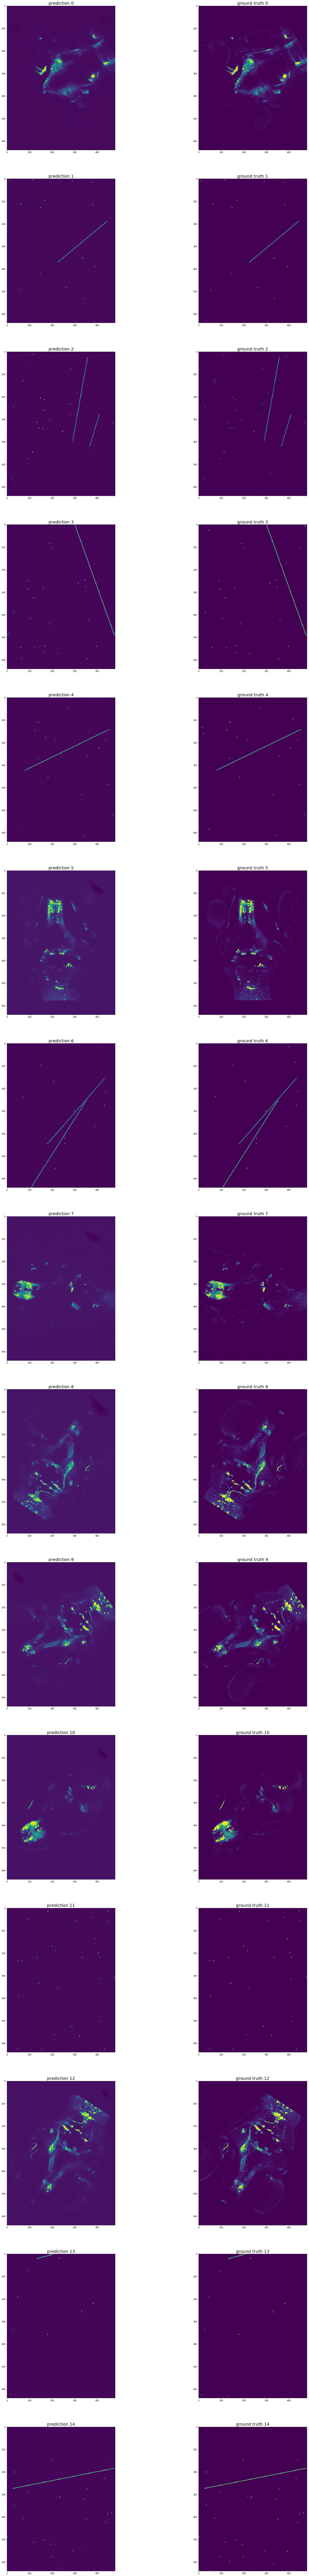

In [28]:
fig=plt.figure(figsize=(30, 15 * NUM_DISPLAY))
rows, columns = NUM_DISPLAY, 2
for i in range(NUM_DISPLAY):
    # Plot prediction
    s = fig.add_subplot(rows, columns, columns*i+1)
    s.set_title("prediction {0}".format(i), size=20)
    plt.imshow(preds[i])
    
    # Plot ground truth
    s = fig.add_subplot(rows, columns, columns*i+2)
    s.set_title("ground truth {0}".format(i), size=20)
    plt.imshow(ground_truths[i])
    
plt.savefig('zebrafish_and_beads_validation.pdf')